In [1]:
import rpy2

%load_ext rpy2.ipython

In [17]:
%%R
library(tidyverse)
library(ggpubr)

In [21]:
%%R
df20 <- read_delim('../results/combined/all.csv', delim=',') %>% group_by(genus,species) %>% mutate(recomb_bin = ntile(cm_per_mb, 20))
pg_namedf <- read_delim('../data/genus_phylogenetic_group_metadata.txt', delim='\t')
merge_pg_name <- left_join(df20,pg_namedf, by = c('genus'='genus'))
merge_pg_name$pg_name <- as_factor(merge_pg_name$pg_name)
nes <- read_delim('../results/model/Nested_model/Ne_Pi_recomb.csv', delim = ',') %>% select('genus','species','NE_MEAN','NE_MEDIAN')
nes <- nes %>% 
    group_by(genus,species) %>%
    reframe(
        NE_MEAN = mean(NE_MEAN),
        NE_MEDIAN = mean(NE_MEDIAN))

tester <- merge_pg_name %>% filter(!(chr=='chrX')) %>% 
    filter(freq_mean > 0.5) %>%
    filter(!(species %in% c('zaza','albinasus'))) %>%
    group_by(pg_name,genus,species) %>% 
    mutate(
        sd_pi = sd(PI),
        all_mean_pi = mean(PI),
        sd_cm_per_mb = sd(cm_per_mb),
        mean_cm_per_mb = mean(cm_per_mb)
    ) %>%
    group_by(pg_name,genus,species, recomb_bin) %>%
    reframe(
        mean_pi = mean(PI),
        sd_pi_all = mean(sd_pi),
        mean_pi_all = mean(all_mean_pi),
        sd_cm_all = mean(sd_cm_per_mb),
        mean_cm_all = mean(mean_cm_per_mb),
        cm_per_mb = mean(cm_per_mb),
        z_pi = (mean_pi-mean_pi_all)/sd_pi_all,
        z_cm = (cm_per_mb-mean_cm_all)/sd_cm_all
        ) 

merged_tibble <- left_join(nes,tester, by = c('species' = 'species', 'genus'='genus'))
merged_tibble

Rows: 5257244 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (3): chr, species, genus
dbl (13): start, end, freq_mean, freq_min, freq_max, freq_median, window_siz...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 57 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): genus, pg_name

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 5071829 Columns: 25
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (4): genus, species, FAMILY, chr
dbl (21): ...1, Unnamed: 0, MEAN, MEDIAN, VARIANCE, NE_MEAN, NE_MEDIAN, NE_V...

ℹ Use `spec()` to retrieve the full column specifi

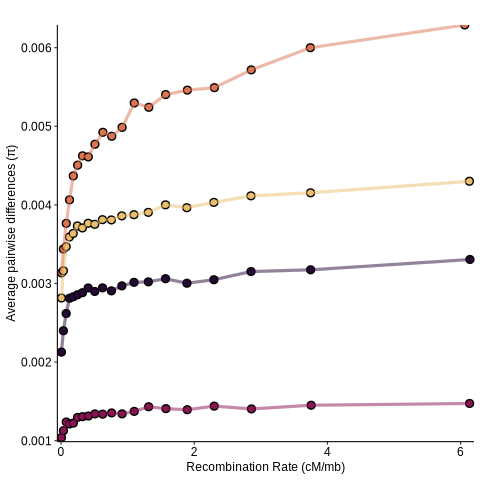

In [22]:
%%R
pi_r_example <- merged_tibble %>%  
    filter(genus %in% c('Pongo','Eulemur','Macaca','Pithecia') & species %in% c('abelii','fulvus','fascicularis','albicans')) %>%
    ggplot(aes(x = cm_per_mb, y = mean_pi, col = species))+
    geom_point(aes(fill=species),color = 'black', size = 3, alpha = 1, shape = 21, stroke = 1)+
    geom_line(alpha = .5, size =1.5)+
    scale_fill_manual(values = c('#240a34','#891652','#eabe6c','#db7552'))+
    scale_colour_manual(values = c('#240a34','#891652','#eabe6c','#db7552'))+
    labs(x = "Recombination Rate (cM/mb)", y = "Average pairwise differences (π)", title = "", size = 55) +
    ggpubr::theme_pubr(legend = 'none') +
    scale_x_continuous(expand = c(0.01, 0)) +
    scale_y_continuous(expand = expansion(mult = c(0.01,0)))
pi_r_example

In [5]:
import pandas as pd
diff_df = pd.read_csv('../results/model/relative_reduction/relative_reduction_df.csv')

In [6]:
%%R -i diff_df
head(diff_df)

  Unnamed: 0           pg_name    genus     species NE_MEDIAN         min
0          1 New_world_monkeys Alouatta    belzebul  54569.55 0.001607075
1          2 New_world_monkeys Alouatta      caraya  35650.21 0.001239415
2          3 New_world_monkeys Alouatta    discolor  66639.12 0.001812968
3          4 New_world_monkeys Alouatta       juara  65093.40 0.001866872
4          5 New_world_monkeys Alouatta macconnelli  61665.26 0.001782060
5          6 New_world_monkeys Alouatta   nigerrima  64413.65 0.001729485
          max slope_mikkel  average_pi         diff
0 0.002390618    0.3277573 0.001998846 0.0007835424
1 0.001602875    0.2267549 0.001421145 0.0003634597
2 0.002896868    0.3741627 0.002354918 0.0010838999
3 0.002686452    0.3050790 0.002276662 0.0008195800
4 0.002672485    0.3331825 0.002227272 0.0008904250
5 0.002713583    0.3626566 0.002221534 0.0009840988


In [27]:
%%R 
# (-i a -i b)

a <- read_delim("../results/model/relative_reduction/a_3_04_2024", delim="\t")
b <- read_delim("../results/model/relative_reduction/b_3_04_2024", delim = "\t")
           

# Use the function
x_values <- c()
lower_bounds <- c()
upper_bounds <- c()


for (i in log10(diff_df$NE_MEDIAN)) {
    cred_int <- credibility_interval(i, b$beta, a$alpha)
    x_values <- c(x_values, i)
    lower_bounds <- c(lower_bounds, cred_int[1])
    upper_bounds <- c(upper_bounds, cred_int[2])
}

# Create a data frame
mean_reg_line <- data.frame(
    x = x_values,
    lower_bound = lower_bounds,
    upper_bound = upper_bounds
)

Rows: 8000 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
dbl (3): chain, draw, alpha

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 8000 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
dbl (3): chain, draw, beta

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [28]:
%%R
model_relative_reduction <- ggplot()+
    ggpubr::theme_pubr(legend = 'none')+
    geom_ribbon(data=mean_reg_line, aes(x= x, ymin = lower_bound, ymax = upper_bound), fill='grey', alpha = .5)+
    geom_line(aes(x=log10(diff_df$NE_MEDIAN), y=(mean(a$alpha))+(mean(b$beta)*log10(diff_df$NE_MEDIAN))), lty = 2, size =2)+
    geom_point(data = diff_df, aes(x=log10(NE_MEDIAN),y=slope_mikkel, fill=pg_name), color = 'black', size = 3, alpha = 1, shape = 21, stroke = 1)+
    scale_fill_manual(values=c('#891652','#eabe6c','#db7552','#240a34')) +
    ylab("Relative Reduction in π")+
    xlab('Log10(Ne)')+
    scale_x_continuous(lim = c(4,5.6),expand = c(0, 0))+
    scale_y_continuous(lim = c(0,0.7), expand = expansion(mult = c(0,0)))

In [8]:
%%R
posterior_predictive <- function(x, slope_samples, intercept_samples) {
  slope_samples * x + intercept_samples
}

# Calculate the credibility interval
credibility_interval <- function(x, slope_samples, intercept_samples, prob = c(0.025, 0.975)) {
  quantile(posterior_predictive(x, slope_samples, intercept_samples), prob)
}

Rows: 8000 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
dbl (3): chain, draw, alpha

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 8000 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
dbl (3): chain, draw, beta

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


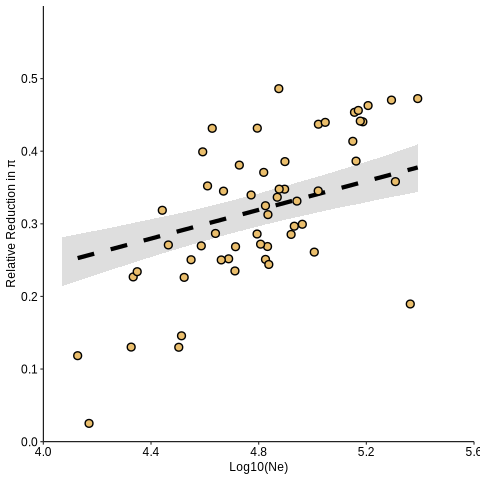

In [9]:
%%R
## old world monkeys
alpha_old <- read_delim('../results/model/relative_reduction/a_old_world_3_04_2024', delim = '\t')
beta_old <- read_delim('../results/model/relative_reduction/b_old_world_3_04_2024', delim = '\t')
           
# Use the function
x_values_o <- c()
lower_bounds_o <- c()
upper_bounds_o <- c()

# Calculate the credibility intervals for each x value


for (i in log10(diff_df$NE_MEDIAN)) {
    cred_int <- credibility_interval(i, beta_old$beta, alpha_old$alpha)
    x_values_o <- c(x_values_o, i)
    lower_bounds_o <- c(lower_bounds_o, cred_int[1])
    upper_bounds_o <- c(upper_bounds_o, cred_int[2])
}

# Create a data frame
mean_reg_line_o <- data.frame(
    x = x_values_o,
    lower_bound = lower_bounds_o,
    upper_bound = upper_bounds_o
)

old_world_rr <- diff_df %>%
    filter(pg_name == 'Old_world_monkeys') %>%
    ggplot()+
    ggpubr::theme_pubr(legend = 'none')+
    geom_ribbon(data=mean_reg_line_o, aes(x= x, ymin = lower_bound, ymax = upper_bound), fill='grey', alpha = .5)+
    geom_line(aes(x=log10(NE_MEDIAN), y=(mean(alpha_old$alpha))+(mean(beta_old$beta)*log10(NE_MEDIAN))), lty = 2, size =2)+

    geom_point(aes(x=log10(NE_MEDIAN),y=slope_mikkel, fill=pg_name), color = 'black', size = 3, alpha = 1, shape = 21, stroke = 1)+
    scale_fill_manual(values=c('#eabe6c')) +
    ylab("Relative Reduction in π")+
    xlab('Log10(Ne)')+
    scale_x_continuous(expand = c(0, 0), lim = c(4,5.6))+
    scale_y_continuous(expand = expansion(mult = c(0,0)),lim = c(0,0.6))
print(old_world_rr)

Rows: 8000 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
dbl (3): chain, draw, alpha

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 8000 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
dbl (3): chain, draw, beta

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


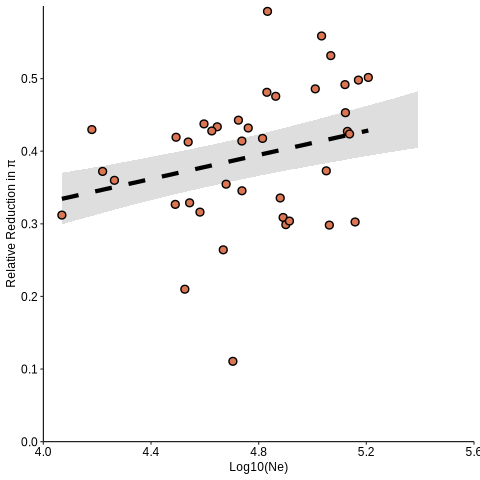

In [11]:
%%R
## prosimians
alpha_prosimians<- read_delim('../results/model/relative_reduction/a_prosimians_3_04_2024', delim = '\t')
beta_prosimians <- read_delim('../results/model/relative_reduction/b_prosimians_3_04_2024', delim = '\t')
           

# Use the function
x_values_p <- c()
lower_bounds_p <- c()
upper_bounds_p <- c()

# Calculate the credibility intervals for each x value
#p <- diff_df %>%
#    filter(pg_name == 'Prosimians')

for (i in log10(diff_df$NE_MEDIAN)) {
    cred_int <- credibility_interval(i, beta_prosimians$beta, alpha_prosimians$alpha)
    x_values_p <- c(x_values_p, i)
    lower_bounds_p <- c(lower_bounds_p, cred_int[1])
    upper_bounds_p <- c(upper_bounds_p, cred_int[2])
}

# Create a data frame
mean_reg_line_p <- data.frame(
    x = x_values_p,
    lower_bound = lower_bounds_p,
    upper_bound = upper_bounds_p
)

prosimians_rr <- diff_df %>%
    filter(pg_name == 'Prosimians') %>%
    ggplot()+
    ggpubr::theme_pubr(legend = 'none')+
    geom_ribbon(data=mean_reg_line_p, aes(x= x, ymin = lower_bound, ymax = upper_bound), fill='grey', alpha = .5)+
    geom_line(aes(x=log10(NE_MEDIAN), y=(mean(alpha_prosimians$alpha))+(mean(beta_prosimians$beta)*log10(NE_MEDIAN))), lty = 2, size =2)+
    geom_point(aes(x=log10(NE_MEDIAN),y=slope_mikkel, fill=pg_name), color = 'black', size = 3, alpha = 1, shape = 21, stroke = 1)+
    scale_fill_manual(values=c('#db7552')) +
    ylab("Relative Reduction in π")+
    xlab('Log10(Ne)')+
    scale_x_continuous(expand = c(0, 0),lim = c(4,5.6))+
    scale_y_continuous(expand = expansion(mult = c(0,0)),lim = c(0.0,0.6))
print(prosimians_rr)

Rows: 8000 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
dbl (3): chain, draw, alpha

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 8000 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
dbl (3): chain, draw, beta

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


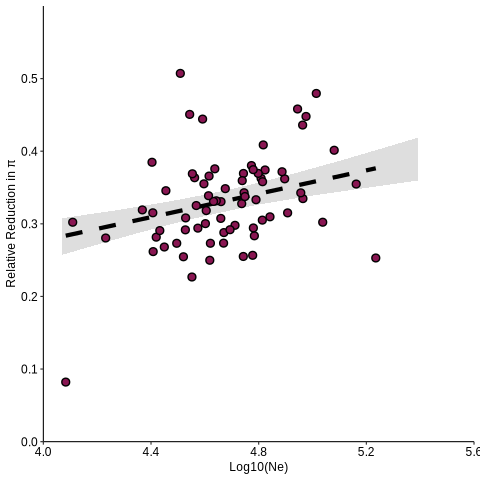

In [12]:
%%R
## new world monkeys
alpha_new <- read_delim('../results/model/relative_reduction/a_new_world_3_04_2024', delim = '\t')
beta_new <- read_delim('../results/model/relative_reduction/b_new_world_3_04_2024', delim = '\t')
           
# Use the function
x_values_n <- c()
lower_bounds_n <- c()
upper_bounds_n <- c()

# Calculate the credibility intervals for each x value


for (i in log10(diff_df$NE_MEDIAN)) {
    cred_int <- credibility_interval(i, beta_new$beta, alpha_new$alpha)
    x_values_n <- c(x_values_n, i)
    lower_bounds_n <- c(lower_bounds_n, cred_int[1])
    upper_bounds_n <- c(upper_bounds_n, cred_int[2])
}

# Create a data frame
mean_reg_line_n <- data.frame(
    x = x_values_n,
    lower_bound = lower_bounds_n,
    upper_bound = upper_bounds_n
)


new_wolrd_rr <- diff_df %>%
    filter(pg_name == 'New_world_monkeys') %>%
    ggplot()+
    ggpubr::theme_pubr(legend = 'none')+
    geom_ribbon(data=mean_reg_line_n, aes(x= x, ymin = lower_bound, ymax = upper_bound), fill='grey', alpha = .5)+
    geom_line(aes(x=log10(NE_MEDIAN), y=(mean(alpha_new$alpha))+(mean(beta_new$beta)*log10(NE_MEDIAN))), lty = 2, size =2)+
    geom_point(aes(x=log10(NE_MEDIAN),y=slope_mikkel, fill=pg_name), color = 'black', size = 3, alpha = 1, shape = 21, stroke = 1)+
    scale_fill_manual(values=c('#891652')) +
    ylab("Relative Reduction in π")+
    xlab('Log10(Ne)')+
    scale_x_continuous(expand = c(0, 0),lim = c(4,5.6))+
    scale_y_continuous(expand = expansion(mult = c(0,0)),lim= c(0,0.6))
print(new_wolrd_rr)

Rows: 8000 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
dbl (3): chain, draw, alpha

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 8000 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
dbl (3): chain, draw, beta

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


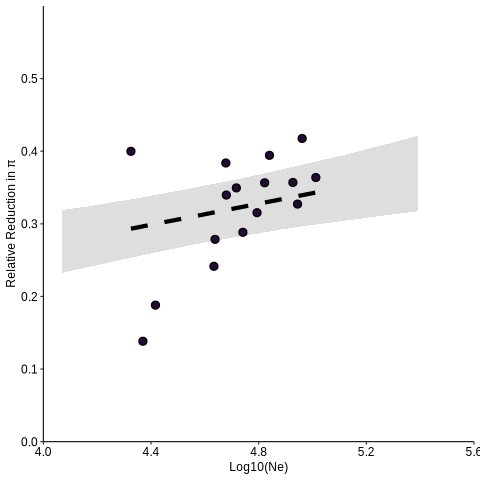

In [13]:
%%R
## great apes
alpha_great <- read_delim('../results/model/relative_reduction/a_great_apes_3_04_2024', delim = '\t')
beta_great <- read_delim('../results/model/relative_reduction/b_great_apes_3_04_2024', delim = '\t')
           
# Use the function
x_values_g <- c()
lower_bounds_g <- c()
upper_bounds_g <- c()

# Calculate the credibility intervals for each x value


for (i in log10(diff_df$NE_MEDIAN)) {
    cred_int <- credibility_interval(i, beta_great$beta, alpha_great$alpha)
    x_values_g <- c(x_values_g, i)
    lower_bounds_g <- c(lower_bounds_g, cred_int[1])
    upper_bounds_g <- c(upper_bounds_g, cred_int[2])
}

# Create a data frame
mean_reg_line_g <- data.frame(
    x = x_values_g,
    lower_bound = lower_bounds_g,
    upper_bound = upper_bounds_g
)

great_apes_rr <- diff_df %>%
    filter(pg_name == 'Great_apes') %>%
    ggplot()+
    ggpubr::theme_pubr(legend = 'none')+
    geom_ribbon(data=mean_reg_line_g, aes(x= x, ymin = lower_bound, ymax = upper_bound), fill='grey', alpha = .5)+
    geom_line(aes(x=log10(NE_MEDIAN), y=(mean(alpha_great$alpha))+(mean(beta_great$beta)*log10(NE_MEDIAN))), lty = 2, size =2)+

    geom_point(aes(x=log10(NE_MEDIAN),y=slope_mikkel, fill=pg_name), color = 'black', size = 3, alpha = 1, shape = 21, stroke = 1)+
    scale_fill_manual(values=c('#240a34')) +
    ylab("Relative Reduction in π")+
    xlab('Log10(Ne)')+
    scale_x_continuous(expand = c(0, 0),lim = c(4,5.6))+
    scale_y_continuous(expand = expansion(mult = c(0,0)),lim = c(0,0.6))
print(great_apes_rr)

R[write to console]: Picking joint bandwidth of 0.00284



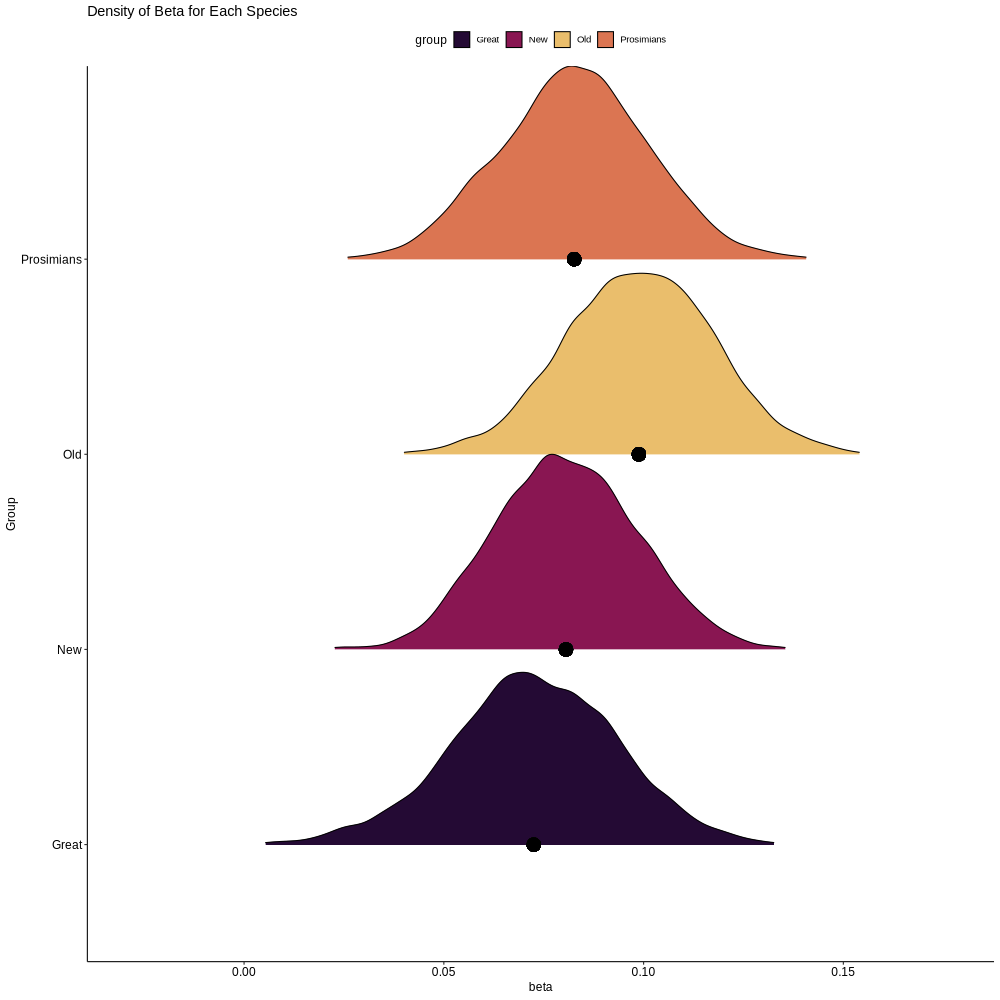

In [31]:
%%R -h 1000 -w 1000
# Load necessary libraries
library(ggplot2)
library(ggridges)
library(dplyr)

# Combine all dataframes into one and add a 'group' column
combined_data <- bind_rows(
  mutate(beta_prosimians, group = 'Prosimians'),
  mutate(beta_old, group = 'Old'),
  mutate(beta_new, group = 'New'),
  mutate(beta_great, group = 'Great')
)

# Create a joyplot
rr_betas <- ggplot() +
  geom_density_ridges_gradient(data=combined_data, aes(x = beta, y = group, fill = group),alpha = .5, scale = 1, rel_min_height = 0.01) +
  scale_fill_manual(values = c('#240a34', '#891652', '#eabe6c', '#db7552')) +
  theme_ridges(font_size = 13, grid = F) +
  xlab('beta') +
  ylab('Group') +
  ggtitle('Density of Beta for Each Species') +
    ggpubr::theme_pubr()

# Add vertical lines for the mean of each group
for(group in unique(combined_data$group)) {
  rr_betas <- rr_betas + 
    geom_point(data = filter(combined_data, group == !!group), 
               aes(x = mean(beta), y = group, color = group), 
               size = 6, alpha = .5, col = 'black')
}

# Print the plot
print(rr_betas)


In [34]:
%%R -h 1000 -w 2000
fig2 <- ggarrange(pi_r_example, model_relative_reduction, ggarrange(ggarrange(great_apes_rr, new_wolrd_rr, old_world_rr, prosimians_rr, ncol = 2, nrow= 2),rr_betas,nrow=2), ncol=3,widths = c(4,3,3))
fig2
ggsave('figures_for_article/relative_reduction_fig2.svg',fig2,width = 17, height = 10, dpi = 500)
ggsave('figures_for_article/relative_reduction_fig2.png',fig2,width = 17, height = 10, dpi = 500)

R[write to console]: Picking joint bandwidth of 0.00284

